In [85]:
# which versions?
%%bash
MKL_NUM_THREADS=4
OMP_NUM_THREADS=4

cat > requirements.txt << EOF
numpy
matplotlib
scipy
pymc3==3.9.0
arviz
pandas
EOF

pip install -r requirements.txt

In [2]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np

import theano
from theano.ifelse import ifelse
from theano import tensor

import pymc3 as pm
from pymc3 import  *
print('Runing on PyMC3 v{}'.format(pm.__version__))

Runing on PyMC3 v3.9.0


In [3]:
az.style.use('arviz-darkgrid')

In [4]:
# Value (in chilean pesos) of the permit that traders pay to fishers per legal unit
visa = 3000.    
C_i = 5000.       # Illegal price of reference at the port per unit: This comes from my fieldwork 1
C_l = C_i + visa  # Elasticity of demand at the port for legal, based on previous and current catch
# C_i = C_i       # Elasticity of demand at the port for illegal, based on previous and current catch

f = 9.2e+05  # Fine expected per box, from chilean law

# Days of operation
daysop = 200.

# beta is price_premium, i.e. how much more expensive legal than illegal price is, 
# P_l = P_i + beta
P_i = 17000.  # Illegal price of reference at market per unit: This comes from my fieldwork 2
beta_min = 0.
beta_max = 6000.  # unrealistically high higher limit

# Probability of detection per box
# The number 5e-05 comes from the enforcement records data, 
theta_min = 0.
theta_max = 3 * 5e-05

# Prior for landings (total units landed each year, considering legal and illegal)
quota = 3200000. / 27.  # 3200 ton quota in 2018. Divided in 27 because "units" are 27 kg boxes
# TODO shouldn't nmin be 3*quota?
T_min = quota / daysop  # Landings lower limit: 3X the legal quota is from one of our papers
T_max = (27000000. / 27.) / daysop  # Landings higher limit: 27,4K ton is from our paper as well

sigma = quota * (10. / 100.) / 3.  # solves 3 * sigma = 10% quota since with P(|x-mu|<3*sigma)=99.73

In [5]:
class MyModel(pm.Model):
    def __init__(self, name='', model=None):
        super().__init__(name, model)
        
        # Define priors
        beta = Uniform('beta', beta_min, beta_max)
        theta = Uniform('theta', theta_min, theta_max)  # Emile: have a mean from enforcement data, should use that (e.g. Gamma prior)
        T = Uniform('T', T_min, T_max)

        # Model for one time period
        P_l = P_i + beta
        # Function 6 in draft, calculates the optimal quantity of illegal units. Divided by 100 to convert to ratio
        # x_i = ((((P_i - wi - pl + wl - (fb * D)) / (8 * D * pl)))) / 100.  # Illegal units
        x_i_possibly_out_of_bounds = (P_i - C_i - (f * theta) - P_l + C_l) / (2 * theta * P_l)
        x_i_not_negative = theano.ifelse.ifelse(tensor.lt(x_i_possibly_out_of_bounds, 0.), 
                                                0. * x_i_possibly_out_of_bounds, 
                                                x_i_possibly_out_of_bounds)
        x_i = theano.ifelse.ifelse(tensor.gt(x_i_not_negative, T), 
                                   T, 
                                   x_i_not_negative)
        x_l = T - x_i
        # Calculates the total (for a year)
        T_per_year = T * daysop
        x_l_per_year = x_l * daysop

        # if we want to be able to plot posterior distributions over these intermediate variables we have to do this
        P_l = pm.Deterministic('P_l', P_l)
        x_i = pm.Deterministic('x_i', x_i)
        x_l = pm.Deterministic('x_l', x_l)
        T_per_year = pm.Deterministic('T_per_year', T_per_year)
        x_l_per_year = pm.Deterministic('x_l_per_year', x_l_per_year)

        # Define likelihood
        likelihood = Normal('quota', mu=T_per_year, sigma=sigma, observed=quota)  # Emile: are we not observing "landings", i.e x_l * dayopt ?

mymodel = MyModel()

In [ ]:
with Model() as model:
    MyModel()
    
    # Inference
    # Draw 11000 posterior samples using NUTS
    trace = sample(draws=11000, chains=2, cores=1)# tune=1000, chains=4, cores=4, target_accept=0.95) # not running in parallel?

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [T, theta, beta]


In [93]:
## With a yearly discretization and using Rodrigo's suppementary material for prior bounds

# observations
yearly_landings = np.array([103615.0, 100472.0, 101905.7,  88051.0,  90643.0,  82931.0])
# weeks = 49
#sigma = quota * (10. / 100.) / 3.
sigma = np.std(yearly_landings)
print("sigma", sigma)

# Prior

# Dmax= (pbox-wbox-(pbox+ppmean)+(wbox+visa))/(((nmean*0.67)*(pbox+ppmean))+fb)  # from Rodrigo
beta_min = 2. / 100. * P_i #  Emile: Brings instabilities if 0
beta_max = 3000.  # From Rodrigo
beta_mean = (beta_max - beta_min) / 2
print("beta", beta_min, beta_max)

#nmin=(quota / weeks) * 3  # from Rodrigo
T_min = quota * 3 / 1
T_max = quota * 9 / 1
T_mean = (T_max - T_min) / 2

theta_max = (P_i - C_i - (P_i + beta_mean) + (C_i + visa)) / (((T_mean * 0.67) * (P_i + beta_mean)) + f)
#theta_max = 3 * 5e-05
theta_min = 0. #theta_max / 3.
print("theta", theta_min, theta_max)

sigma 7787.132765819521
beta 340.0 3000.0
theta 0.0 3.823668584861019e-07


In [94]:
class YearlyLandings(pm.Model):
    def __init__(self, name='', model=None):
        super().__init__(name, model)
        
        # Define priors
        beta = Uniform('beta', beta_min, beta_max)
        theta = Uniform('theta', theta_min, theta_max)
        T = Uniform('T', T_min, T_max)

        # Model for one time period
        P_l = P_i + beta
        # Function 6 in draft, calculates the optimal quantity of illegal units. Divided by 100 to convert to ratio
        # x_i = ((((P_i - wi - pl + wl - (fb * D)) / (8 * D * pl)))) / 100.  # Illegal units
        # x_i = (P_i - C_i - (f * theta) - P_l + C_l) / (2 * theta * P_l) = (visa - beta - (f * theta)) / (2 * theta * P_l)
        x_i_possibly_out_of_bounds = (visa - beta) /  (2 * theta * P_l) - f / (2 * P_l)
        x_i_not_negative = ifelse(tensor.lt(x_i_possibly_out_of_bounds, 0.), 0. * x_i_possibly_out_of_bounds, x_i_possibly_out_of_bounds)
        x_i = ifelse(tensor.gt(x_i_not_negative, T), T, x_i_not_negative)
        x_i = x_i # should multiply by 5 * weeks??
        x_l = T - x_i
        r = x_i / T

        # Save variables
        P_l = pm.Deterministic('P_l', P_l)
        x_i = pm.Deterministic('x_i', x_i)
        x_l = pm.Deterministic('x_l', x_l)
        r = pm.Deterministic('r', r)  # from Rodrigo's supplementary material: low scenario: 67%, high scenario 88%
        log_theta = pm.Deterministic('log_theta', np.log(theta))

        # Define likelihood
        # observations (landings) are the (weekly / yearly) LEGAL units
        likelihood = Normal('landings', mu=x_l, sigma=sigma, observed=yearly_landings, shape=(len(yearly_landings),))

mymodel = YearlyLandings()

In [95]:
with Model() as model:
    YearlyLandings()
    
    # Inference
    # Draw 11000 posterior samples using NUTS
    trace = sample(draws=5000, chains=2, cores=2, target_accept=0.9)# 

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [T, theta, beta]


Sampling 2 chains for 1_000 tune and 5_000 draw iterations (2_000 + 10_000 draws total) took 183 seconds.
INFO (theano.gof.compilelock): Refreshing lock /root/.theano/compiledir_Linux-4.19.112+-x86_64-with-Ubuntu-18.04-bionic-x86_64-3.6.9-64/lock_dir/lock
There were 187 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7391618942785992, but should be close to 0.9. Try to increase the number of tuning steps.
There were 153 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.


# Prior predictive check

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fefb9843400>,
      dtype=object)

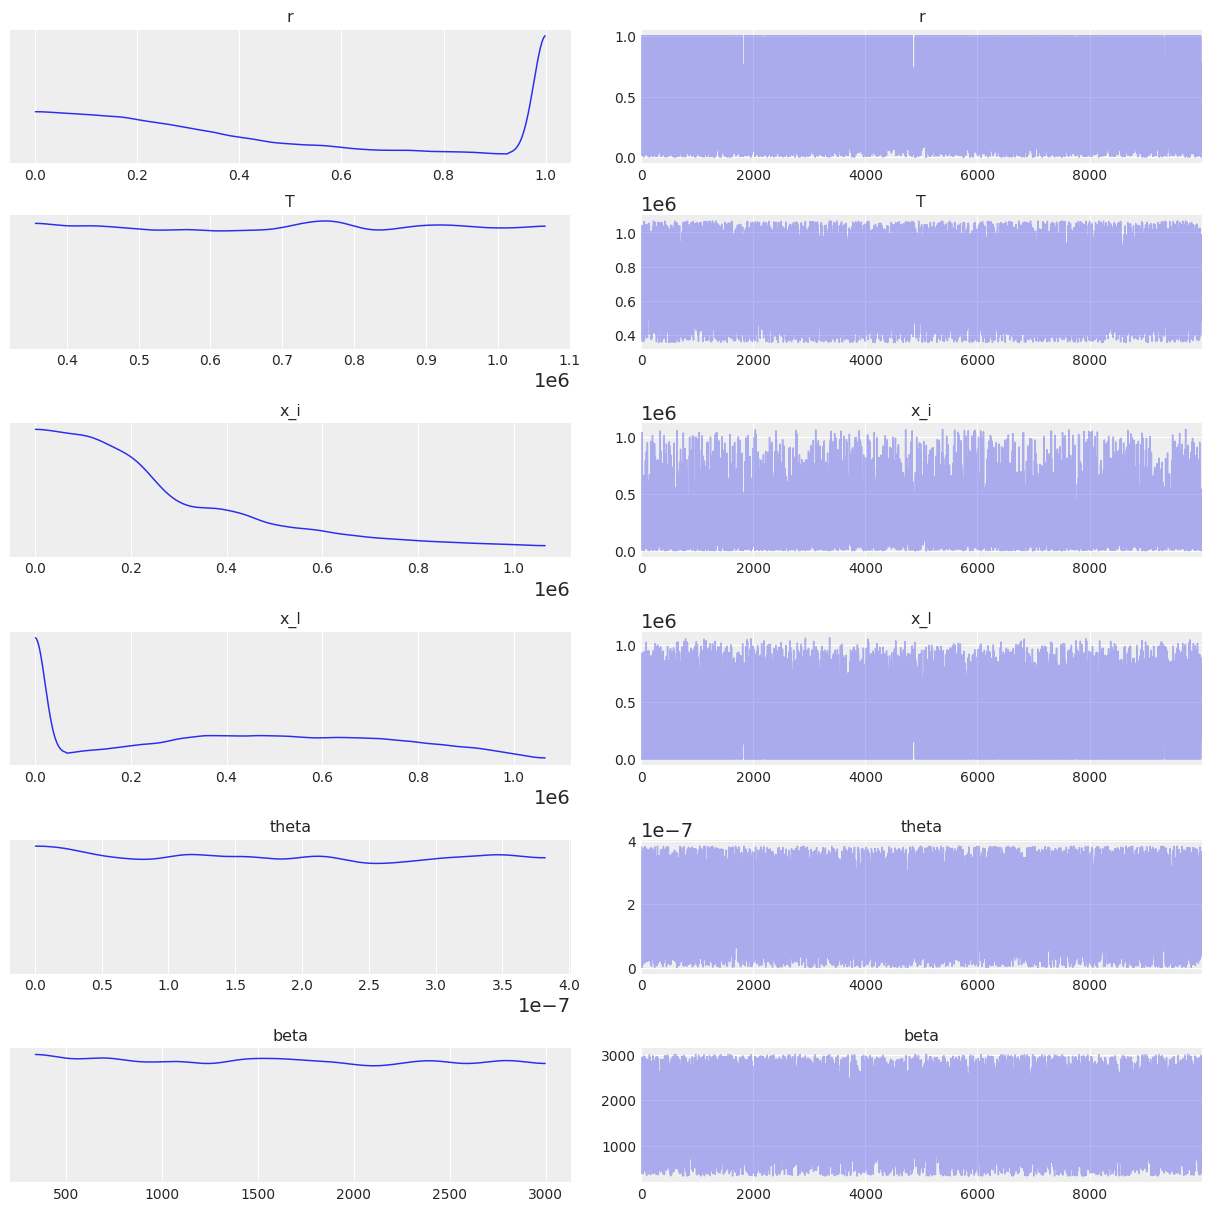

In [96]:
prior_checks = sample_prior_predictive(samples=10000, random_seed=0, model=mymodel)
#traceplot(prior_checks)
# traceplot({k: prior_checks[k] for k in ('x_i', 'x_l')})
traceplot({k: prior_checks[k] for k in ('r', 'T', 'x_i', 'x_l', 'theta', 'beta')})

# [Diagnosis](https://docs.pymc.io/notebooks/Diagnosing_biased_Inference_with_Divergences.html)

In [97]:
#display the total number and percentage of divergent
divergent = trace['diverging']
print('Number of Divergent %d' % divergent.nonzero()[0].size)
divperc = divergent.nonzero()[0].size / len(trace) * 100
print('Percentage of Divergent %.1f' % divperc)

Number of Divergent 340
Percentage of Divergent 6.8


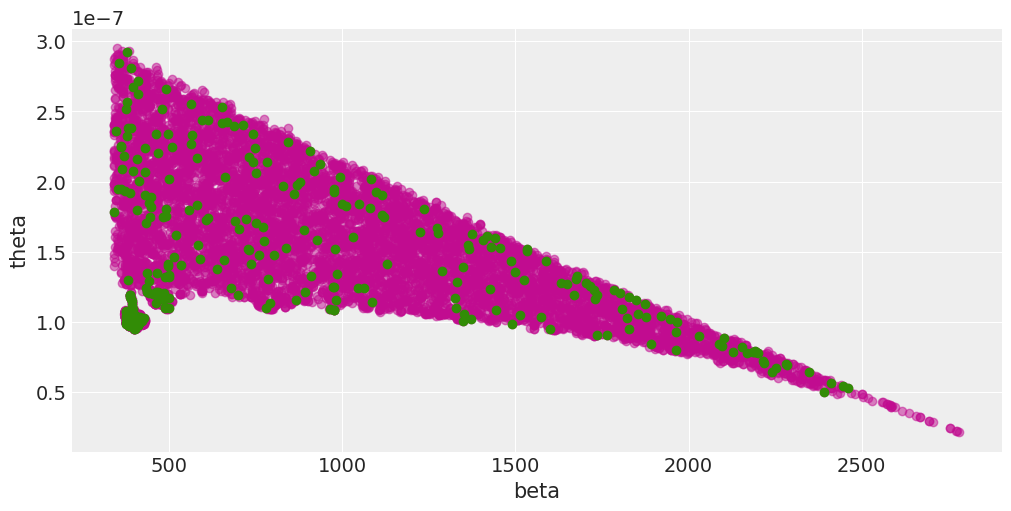

In [98]:
def pairplot_divergence(trace, vars, ax=None, divergence=True, color='C3', divergence_color='C2'):
    var_x = trace.get_values(varname=vars[0], combine=True)
    var_y = trace.get_values(varname=vars[1], combine=True)
    if not ax:
        _, ax = plt.subplots(1, 1, figsize=(10, 5))
    ax.plot(var_x, var_y, 'o', color=color, alpha=.5)
    if divergence:
        divergent = trace['diverging']
        ax.plot(var_x[divergent], var_y[divergent], 'o', color=divergence_color)
    ax.set_xlabel(vars[0])
    ax.set_ylabel(vars[1])
    # ax.set_title('scatter plot between log(tau) and theta[0]');
    return ax

pairplot_divergence(trace, ["beta", "theta"]);

In [99]:
print(model.vars)
print(model.deterministics)

[beta_interval__, theta_interval__, T_interval__]
[beta, theta, T, P_l, x_i, x_l, r, log_theta]


INFO (theano.gof.compilelock): Refreshing lock /root/.theano/compiledir_Linux-4.19.112+-x86_64-with-Ubuntu-18.04-bionic-x86_64-3.6.9-64/lock_dir/lock


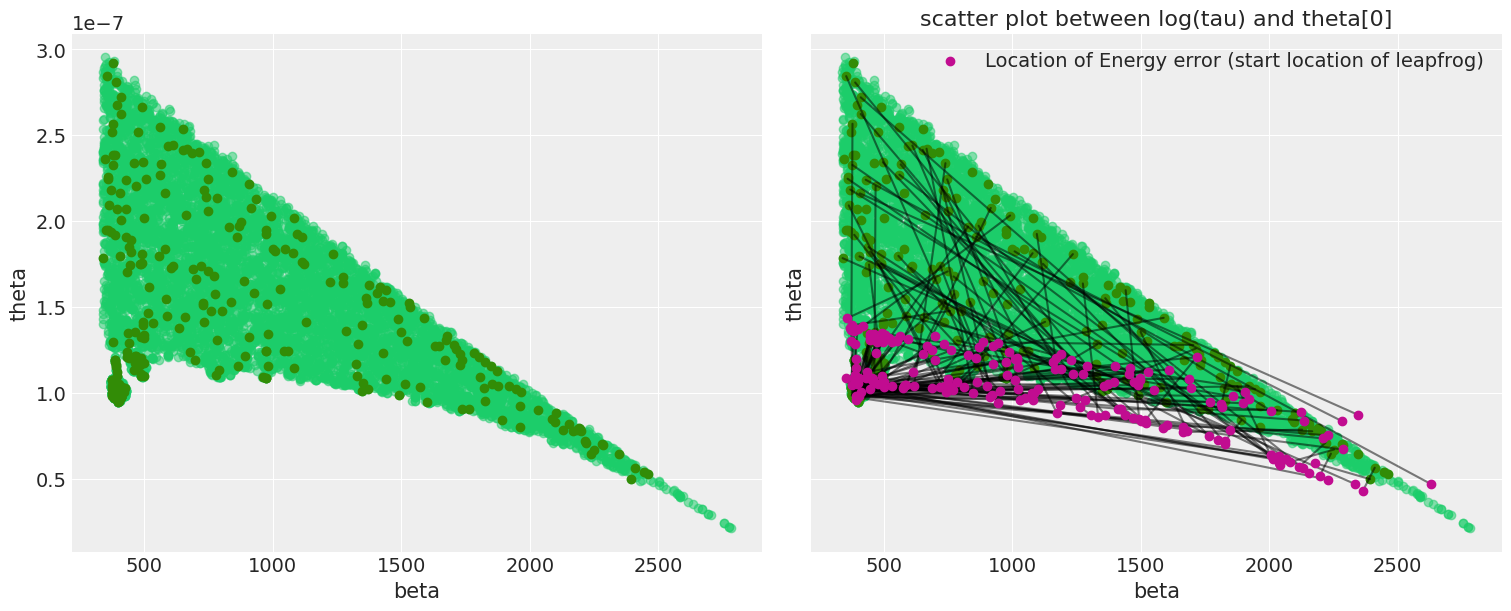

In [100]:
from collections import defaultdict

def pairplot_divergence2(trace, vars):

  divergent_point = defaultdict(list)

  chain_warn = trace.report._chain_warnings
  for i in range(len(chain_warn)):
      for warning_ in chain_warn[i]:
          #print(warning_)
          if warning_.step is not None and warning_.extra is not None:
          #if warning_.step is not None and warning_.divergence_point_source is not None:
              for RV in model.free_RVs:
                  #print(RV)
                  para_name = RV.name
                  value = model[para_name.split("_")[0]].distribution.transform.backward(warning_.extra[para_name]).eval()
                  divergent_point[para_name].append(value)
                  #divergent_point[para_name].append(warning_.extra[para_name])

  for RV in model.free_RVs:
      para_name = RV.name
      divergent_point[para_name] = np.asarray(divergent_point[para_name])
  ii = 5

  var_y_d = divergent_point[vars[1] + "_interval__"]
  var_x_d = divergent_point[vars[0] + "_interval__"]#[:, ii]
  Ndiv_recorded = len(var_y_d)

  _, ax = plt.subplots(1, 2, figsize=(15, 6), sharex=True, sharey=True)

  pairplot_divergence(trace, vars, ax=ax[0], color='C7', divergence_color='C2')

  plt.title('scatter plot between log(tau) and theta[0]')

  pairplot_divergence(trace, vars, ax=ax[1], color='C7', divergence_color='C2')

  var_x = trace[vars[0]]
  var_y = trace[vars[1]]

  ax[1].plot([var_x[divergent == 1][:Ndiv_recorded], var_x_d],
            [var_y[divergent == 1][:Ndiv_recorded], var_y_d],
            'k-', alpha=.5)

  ax[1].scatter(var_x_d, var_y_d,
                color='C3', zorder=10,
                label='Location of Energy error (start location of leapfrog)')

  plt.title('scatter plot between log(tau) and theta[0]')
  plt.legend();

pairplot_divergence2(trace, ["beta", "theta"]);

# Posterior inference

In [ ]:
plt.figure(figsize=(7, 7))
traceplot(trace)
plt.tight_layout();

# Some debugging

In [ ]:
beta = 1000
theta = 5e-05
T = T_min

# Model for one time period
P_l = P_i + beta
# Function 6 in draft, calculates the optimal quantity of illegal units. Divided by 100 to convert to ratio
# x_i = ((((P_i - wi - pl + wl - (fb * D)) / (8 * D * pl)))) / 100.  # Illegal units
x_i = (P_i - C_i - f * theta - P_l + C_l) / (-2. * theta * P_l)

if x_i < 0:
    x_i = 0.
elif x_i > 0:
    x_i = T
x_l = T - x_i

# Calculates the total (for a year)
T_per_year = T * daysop

P_l, x_i, x_l, T_per_year

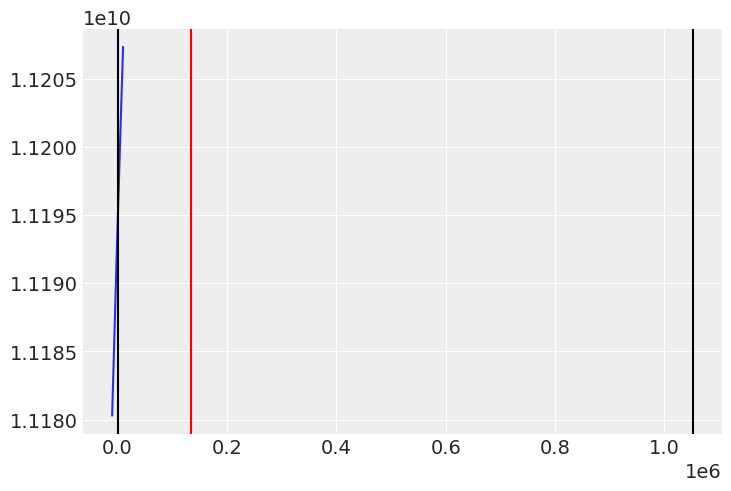

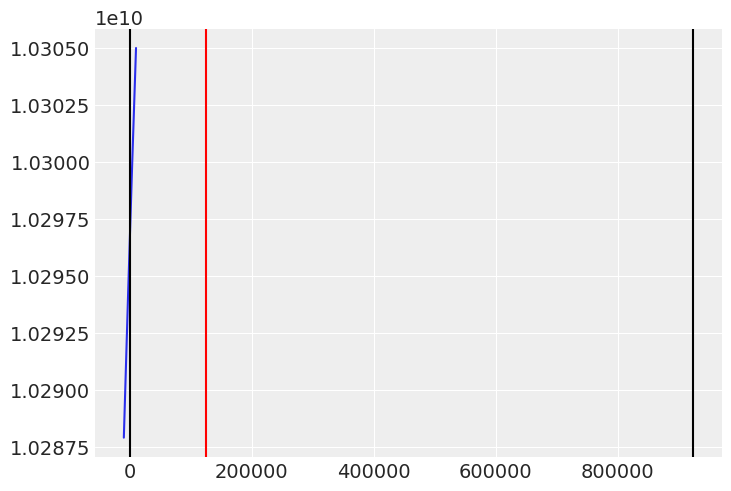

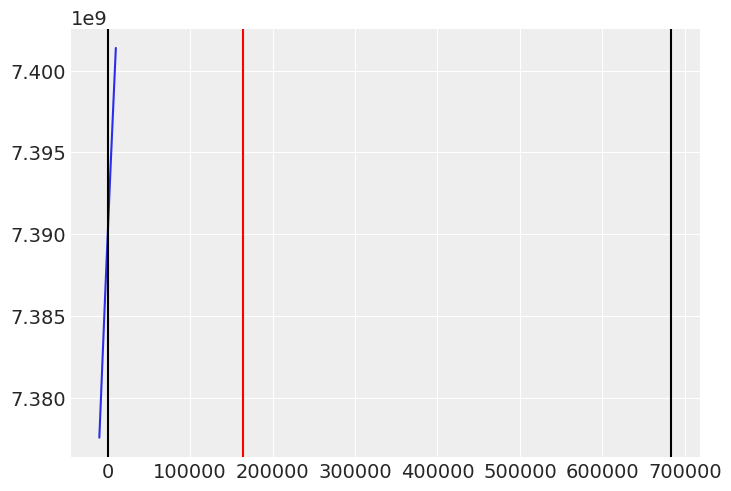

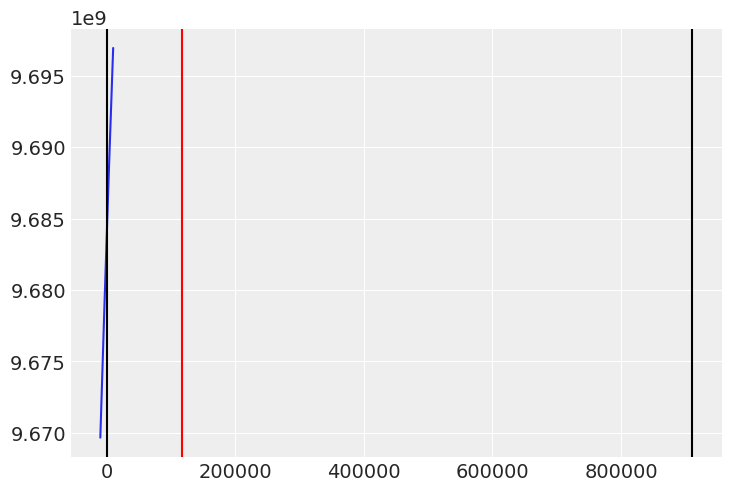

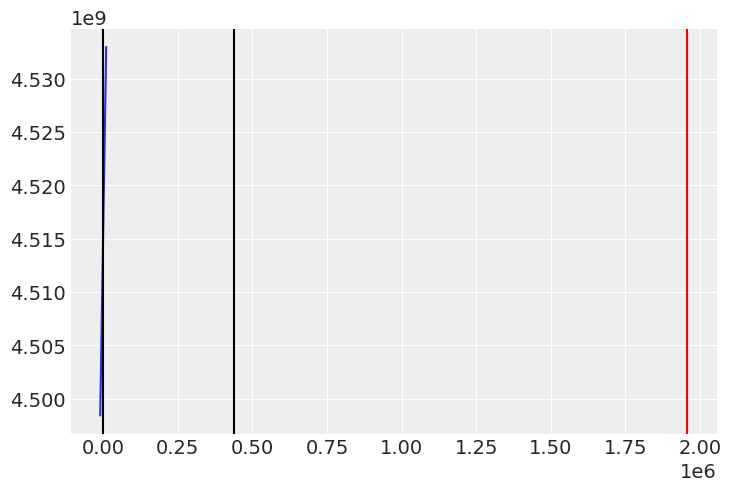

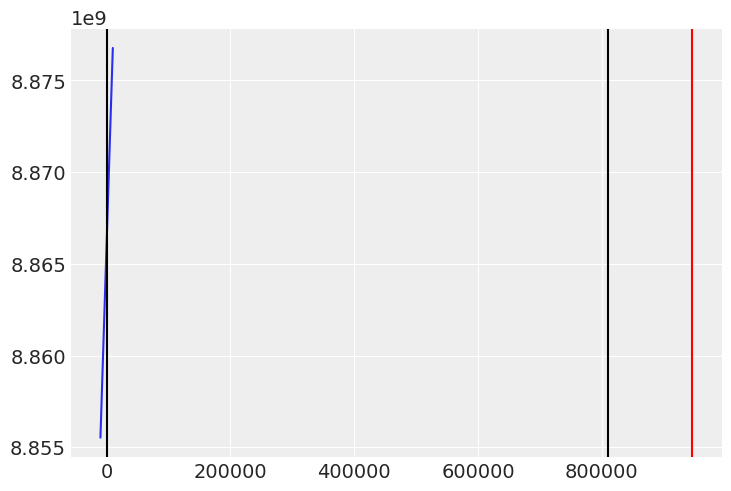

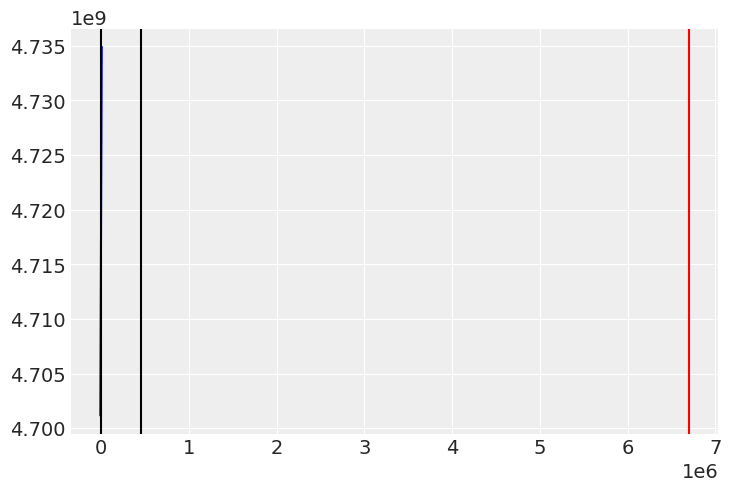

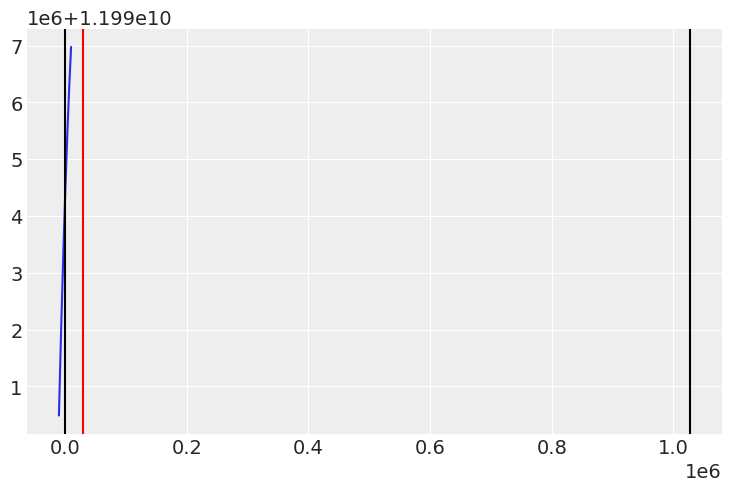

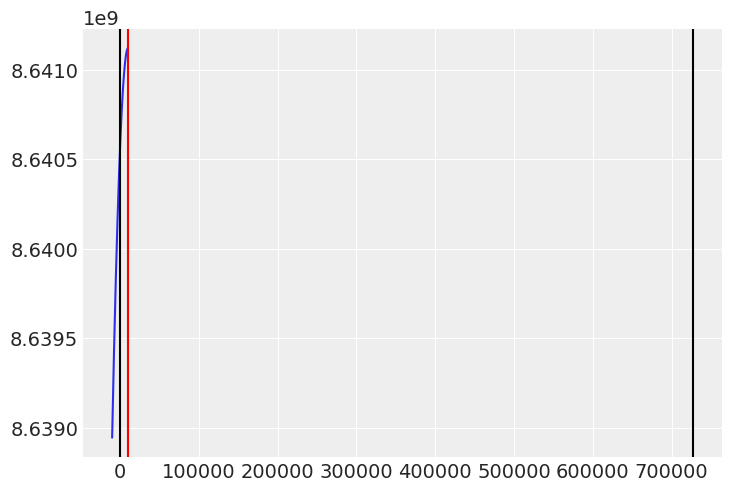

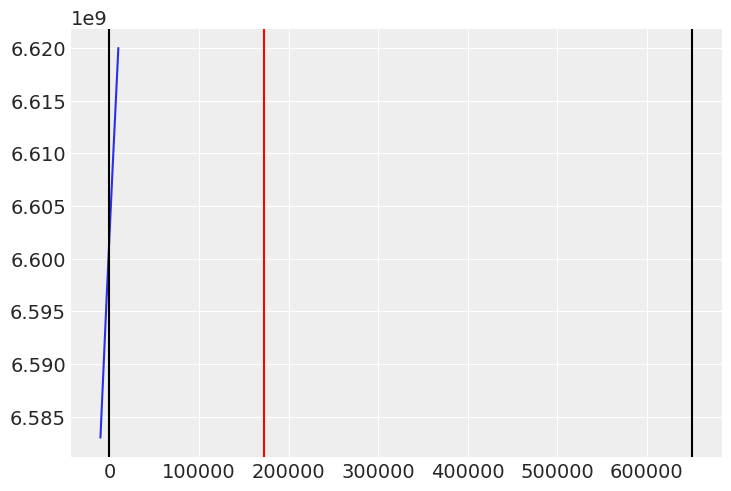

In [24]:
N = 10
samples = sample_prior_predictive(samples=N, random_seed=0, model=mymodel)

for i in range(N):
    theta,P_l,T = tuple(samples[k][i] for k in ('theta,P_l,T'.split(',')))
    
    x_range = 10000
    x_i = np.linspace(-x_range, x_range, 1000)
    x_l = T - x_i
    y = (P_i - C_i)*x_i - (theta * x_i * (P_l * x_i + f)) + (P_l - C_l)*x_l
    
    x_i_opt = (P_i - C_i - f * theta - P_l + C_l) / (2. * theta * P_l)

    plt.plot(x_i, y)
    plt.axvline(0., color='k')
    plt.axvline(T, color='k')
    plt.axvline(x_i_opt, color='r')
    plt.show()